In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torchvision.transforms as transforms
import torchvision.datasets as dset
from PIL import Image
import matplotlib.pyplot as plt

try:
    device = torch.device("cuda:1")
    is_cuda = True
except:
    device = torch.device("cpu")
    is_cuda = False

In [3]:
class NeuralOT(nn.Module):
    def __init__(self, source_dual_net, target_dual_net, source_to_target_net, regularization_parameter=1e-2,
                 regularization_mode='entropy', from_discrete=True, to_discrete=True):
        super().__init__()
        self.from_discrete = from_discrete
        self.to_discrete = to_discrete
        self.u = source_dual_net
        self.v = target_dual_net
        self.f = source_to_target_net
        self.eps = regularization_parameter
        if regularization_mode not in ['entropy', 'l2']:
            raise ValueError("``regularization_mode`` must be ``'entropy'`` or ``'l2'``.")
        self.mode = regularization_mode

    @staticmethod
    def l2_distances(x, y):
        """
        Parameters
        ----------
        x : torch.tensor
            Batch of images from source domain of shape ``(N_s, C, H, W)``.
        y : torch.tensor
            Batch of images from target domain of shape ``(N_t, C, H, W)``.

        Returns
        -------
        distances : torch.tensor
            Tensor of shape ``(N_s, N_t)`` with pairwise l2 distances between source and target images.
        """
        axes = [-(i+1) for i in range(len(x.shape)-1)]
        return torch.sqrt(torch.sum((x - y) ** 2, dim=axes))

    def plan_criterion(self, x, x_idx, y, y_idx):
        """
        Parameters
        ----------
        x : torch.tensor
            Batch of images from source domain of shape ``(N_s, C, H, W)``.
        y : torch.tensor
            Batch of images from target domain of shape ``(N_t, C, H, W)``.

        Returns
        -------
        loss : torch.tensor
            Loss for training dual neural networks.
        """
        self.u.train()
        self.v.train()
        if self.from_discrete:
            u = self.u(x_idx)
        else:
            u = self.u(x)
            
        if self.to_discrete:
            v = self.v(y_idx)
        else:
            v = self.v(y)
        c = self.l2_distances(x, y)

        if self.mode == 'entropy':
            regularization_term = -self.eps * torch.exp((u + v - c) / self.eps)
        else:
            regularization_term = -torch.relu(u + v - c) ** 2 / (4 * self.eps)

        # print("Satisfied: {:.0%}".format(torch.mean(u + v < c, dtype=torch.float)))

        return -torch.mean(u + v + regularization_term)

    def mapping_criterion(self, x, x_idx, y, y_idx):
        """
        Parameters
        ----------
        x : torch.tensor
            Batch of images from source domain of shape ``(N, C, H, W)``.
        y : torch.tensor
            Batch of images from target domain of shape ``(N, C, H, W)``.

        Returns
        -------
        loss : torch.tensor
            Loss for training mapping neural network.
        """
        self.u.eval()
        self.v.eval()
        self.f.train()
        with torch.no_grad():
            if self.from_discrete:
                u = self.u(x_idx)
            else:
                u = self.u(x)
                
            if self.to_discrete:
                v = self.v(y_idx)
            else:
                v = self.v(y)
                
        c = self.l2_distances(x, y)
        mapped = self.f(x)  # shape ``(N, C, H, W)``

        d = self.l2_distances(mapped, y)
        if self.mode == 'entropy':
            h = torch.exp((u + v - c) / self.eps)
        else:
            h = torch.relu(u + v - c) / (2 * self.eps)
        return torch.mean(d * h)

    def map(self, x):
        self.f.eval()
        return self.f(x)

In [4]:
def train(epochs, model, criterion, optimizer, train_loader, val_loader=None, scheduler=None, verbose=True, save_dir=None):
    model.to(device)
    for epoch in range(1, epochs+1):
        model.train()
        loss_avg = 0
        for batch in train_loader:
            for i in range(len(batch)):
                batch[i] = batch[i].to(device)
            optimizer.zero_grad()
            loss = criterion(*batch)
            loss_avg += loss.item()
            loss.backward()
            optimizer.step()
        loss_avg /= len(train_loader)
        
        model.eval()
        val_loss = 0
        if val_loader:
            with torch.no_grad():
                for batch in val_loader:
                    for i in range(len(batch)):
                        batch[i] = batch[i].to(device)
                    val_loss += criterion(*batch)
            val_loss /= len(val_loader)
         
            if scheduler is not None:
                scheduler.step(val_loss)
        else:
            if scheduler is not None:
                scheduler.step(loss_avg)
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            if val_loader:
                print('Epoch {}/{} || Loss:  Train {:.6g} | Validation {:.6g}'.format(epoch, epochs, loss_avg, val_loss.item()))
            else:
                print('Epoch {}/{} || Loss:  Train {:.6g}'.format(epoch, epochs, loss_avg))

In [5]:
class UniformSampler:
    """
    UniformSampler allows to sample batches in random manner without splitting the original data.
    """
    def __init__(self, datasets, batch_size=1, n_batches=1):
        if not isinstance(datasets, list):
            datasets = [datasets]
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.weights = [torch.ones(len(dset)) for dset in datasets]

    def __iter__(self):
        for i in range(self.n_batches):
            idx = [torch.multinomial(w, self.batch_size, replacement=True) for w in self.weights]
            yield torch.stack(idx, dim=1).squeeze()

    def __len__(self):
        return self.batch_size*self.n_batches

class ZipDataset(Dataset):
    """
    ZipDataset represents a dataset that stores several other datasets zipped together.
    """
    def __init__(self, datasets, return_idx=True):
        super().__init__()
        self.datasets = datasets
        self.return_idx = return_idx

    def __getitem__(self, idx):
        items = []
        for ids, dset in zip(idx, self.datasets):
            items.append(dset[ids][0])
            if self.return_idx:
                items.append(ids)

        if len(items) == 1:
            items = items[0]
        
        return items 

    def __len__(self):
        return max([len(dset) for dset in self.datasets])

class ZipLoader(DataLoader):
    def __init__(self, datasets, batch_size, n_batches, *args, return_idx=True, **kwargs):
        """
        ZipLoader allows to sample batches from zipped datasets with possibly different number of elements.
        """
        us = UniformSampler(datasets, batch_size=batch_size, n_batches=n_batches)
        dl = ZipDataset(datasets, return_idx=return_idx)
        self.size = max([len(dset) for dset in datasets])
        super().__init__(dl, *args, batch_sampler=us, **kwargs)
        
    def __len__(self):
        return self.size

In [6]:
class DistributionDataset():
    def __init__(self, distribution, transform=lambda x: x):
        super().__init__()
        self.distribution = distribution
        self.transform = transform
        
    def __getitem__(self, idx):
        return self.transform(self.distribution.sample()), None
    
    def __len__(self):
        return 1

In [7]:
def get_rotation(theta):
    rad = np.radians(theta)
    c, s = np.cos(rad), np.sin(rad)
    R = np.array([[c, -s],
                  [s,  c]])
    return R

from torch.distributions.multivariate_normal import MultivariateNormal

class CircleDataset():
    def __init__(self, n_samples, n_centers=9, sigma=0.02):
        super().__init__()
        self.nus = [torch.zeros(2)]
        self.sigma = sigma
        for i in range(n_centers-1):
            R = get_rotation(i*360/(n_centers-1))
            self.nus.append(torch.tensor([1, 0] @ R, dtype=torch.float))
        classes = torch.multinomial(torch.ones(n_centers), n_samples, 
                                    replacement=True)
        
        data = []
        for i in range(n_centers):
            n_samples_class = torch.sum(classes == i)
            if n_samples_class == 0:
                continue
            dist = MultivariateNormal(self.nus[i], 
                                      torch.eye(2)*self.sigma**2)
            data.append(dist.sample([n_samples_class.item()]))
        self.data = torch.cat(data)
        
    def __getitem__(self, idx):
        return self.data[idx], None
    
    def __len__(self):
        return self.data.shape[0]

In [8]:
class Vector(nn.Module):
    def __init__(self, n_dims):
        super().__init__()
        self.v = nn.Parameter(torch.zeros(n_dims))
        nn.init.xavier_uniform_(self.v[None, :])
    def forward(self, idx):
        return self.v[idx]

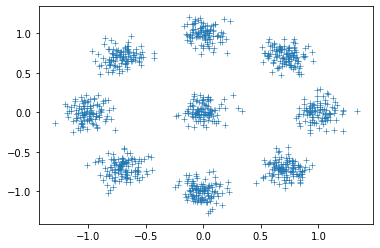

In [9]:
circle_dset = CircleDataset(1000, sigma=0.1)
plt.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], marker="+", lw=0.6)

In [34]:
n_samples = 1000
batch_size = 1000
n_batches = n_samples//batch_size + 1

from torch.distributions.multivariate_normal import MultivariateNormal
distr = MultivariateNormal(torch.zeros(2), 0.4*torch.eye(2))
distr_dset = DistributionDataset(distr)
circle_dset = CircleDataset(n_samples, sigma=0.1)

gauss_loader = ZipLoader([distr_dset, circle_dset], batch_size=batch_size,
                     n_batches=n_batches)

In [35]:
d = []
for X, X_idx, Y, Y_idx in gauss_loader:
    d.append(torch.mean(NeuralOT.l2_distances(X, Y)))
print("Average cost:", sum(d)/len(d))

Average cost: tensor(1.1617)


In [36]:
torch.manual_seed(1)

u = nn.Sequential(nn.Linear(2, 200),
                  nn.BatchNorm1d(200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 1)
                 )
v = Vector(len(circle_dset))
# v = nn.Sequential(nn.Linear(2, 200),
#                   nn.BatchNorm1d(200),
#                   nn.SELU(),
#                   nn.Linear(200, 500),
#                   nn.BatchNorm1d(500),
#                   nn.SELU(),
#                   nn.Linear(500, 500),
#                   nn.BatchNorm1d(500),
#                   nn.SELU(),
#                   nn.Linear(500, 1)
#                  )

# torch.nn.init.normal_(v.v, 1.5, 0.5)
f = nn.Sequential(nn.Linear(2, 200),
                  nn.BatchNorm1d(200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 500),
                  nn.BatchNorm1d(500),
                  nn.SELU(),
                  nn.Linear(500, 2)
                 )

model = NeuralOT(u, v, f, regularization_parameter=1e-2, regularization_mode='l2',
                 from_discrete=False, to_discrete=True)
plan_optimizer = torch.optim.Adam(list(u.parameters())+[v.v], lr=1e-3)
# plan_optimizer = torch.optim.Adam(list(u.parameters())+list(v.parameters()), lr=1e-3)
mapping_optimizer = torch.optim.Adam(f.parameters(), lr=1e-3)
plan_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(plan_optimizer, 
                                                            factor=0.5)
mapping_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mapping_optimizer, 
                                                               factor=0.5)

In [37]:
train(200, model, model.plan_criterion, plan_optimizer, gauss_loader,
      scheduler=plan_scheduler)

Epoch 10/200 || Loss:  Train 0.000305952
Epoch 20/200 || Loss:  Train 7.75244e-05
Epoch 30/200 || Loss:  Train 5.72684e-05
Epoch 40/200 || Loss:  Train 4.33927e-05
Epoch 50/200 || Loss:  Train 3.47153e-05
Epoch 60/200 || Loss:  Train 3.36118e-05
Epoch 70/200 || Loss:  Train 2.95371e-05
Epoch 80/200 || Loss:  Train 2.37378e-05
Epoch 90/200 || Loss:  Train 3.31368e-05
Epoch 100/200 || Loss:  Train 2.64091e-05
Epoch 110/200 || Loss:  Train 3.3919e-05
Epoch 120/200 || Loss:  Train 2.91858e-05
Epoch 130/200 || Loss:  Train 2.04964e-05
Epoch 140/200 || Loss:  Train 2.64679e-05
Epoch 150/200 || Loss:  Train 2.87624e-05
Epoch 160/200 || Loss:  Train 2.87643e-05
Epoch 170/200 || Loss:  Train 3.27222e-05
Epoch 180/200 || Loss:  Train 2.06544e-05
Epoch 190/200 || Loss:  Train 2.68186e-05
Epoch 200/200 || Loss:  Train 2.44077e-05


In [38]:
train(100, model, model.mapping_criterion, mapping_optimizer, gauss_loader,
      scheduler=mapping_scheduler)

Epoch 5/100 || Loss:  Train 2.67674e-05
Epoch 10/100 || Loss:  Train 1.30081e-05
Epoch 15/100 || Loss:  Train 6.8909e-06
Epoch 20/100 || Loss:  Train 3.63643e-06
Epoch 25/100 || Loss:  Train 4.4907e-06
Epoch 30/100 || Loss:  Train 5.31121e-06
Epoch 35/100 || Loss:  Train 2.96049e-06
Epoch 40/100 || Loss:  Train 1.9355e-06
Epoch 45/100 || Loss:  Train 3.29268e-06
Epoch 50/100 || Loss:  Train 8.67851e-06
Epoch 55/100 || Loss:  Train 5.8634e-06
Epoch 60/100 || Loss:  Train 3.9909e-06
Epoch 65/100 || Loss:  Train 3.5821e-06
Epoch 70/100 || Loss:  Train 3.30097e-06
Epoch 75/100 || Loss:  Train 1.65777e-06
Epoch 80/100 || Loss:  Train 1.92304e-06
Epoch 85/100 || Loss:  Train 1.81484e-06
Epoch 90/100 || Loss:  Train 1.62403e-06
Epoch 95/100 || Loss:  Train 2.57136e-06
Epoch 100/100 || Loss:  Train 2.03061e-06


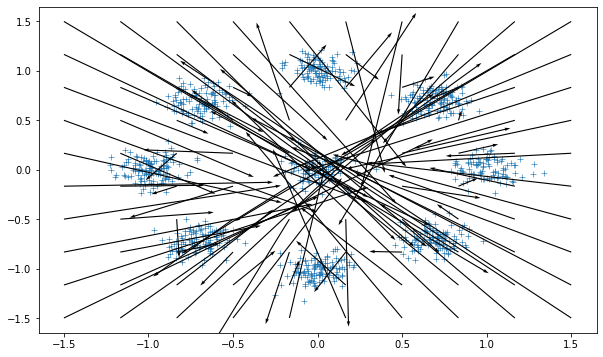

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

xs = np.linspace(-1.5, 1.5, num=10)
ys = np.linspace(-1.5, 1.5, num=10)

XX, YY = np.meshgrid(xs, ys)
XX = torch.tensor(XX.ravel(), dtype=torch.float)
YY = torch.tensor(YY.ravel(), dtype=torch.float)

X = torch.stack([XX, YY], dim=1)
with torch.no_grad():
    Z = model.cpu().map(X).detach()
offsets = Z - X 
ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6)
ax.quiver(XX, YY, offsets[:, 0], offsets[:, 1], angles="xy", scale=1, units="width",
          width=0.002)

ax.set_xlim

plt.show()

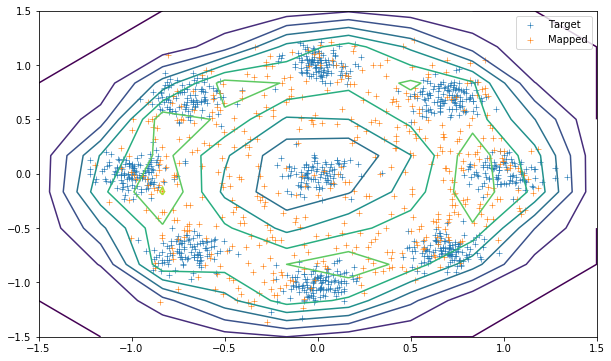

In [40]:
from matplotlib.image import NonUniformImage

n_points = 10000
n_show = 500
idx = np.random.choice(np.arange(n_points, dtype=np.int), n_show,
                       replace=False)
xmin, xmax = -1.5, 1.5
ymin, ymax = -1.5, 1.5
ps = distr.sample([n_points])
with torch.no_grad():
    ps_mapped = model.cpu().map(ps).detach().numpy()

H, xedges, yedges = np.histogram2d(ps_mapped[:, 0], ps_mapped[:, 1], 
                                   range=[[xmin, xmax], [ymin, ymax]])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

ax.contour(H.transpose(), extent=[xedges.min(), xedges.max(), 
                          yedges.min(), yedges.max()])
ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6, label="Target")
ax.scatter(ps_mapped[idx, 0], ps_mapped[idx, 1], 
           marker="+", lw=0.6, label="Mapped")

ax.legend()
plt.show()

In [6]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(*self.shape)

In [10]:
h, w = 16, 16
batch_size = 1000

tr = transforms.Compose([transforms.Resize((h, w)),
                         transforms.ToTensor()])

mnist = dset.MNIST("data/mnist", download=True, transform=tr)
usps = dset.USPS("data/usps", download=True, transform=transforms.ToTensor())

n_batches = max(len(mnist), len(usps))//batch_size + 1
pairs_loader = ZipLoader([mnist, usps], batch_size=batch_size, n_batches=n_batches, 
                          pin_memory=is_cuda, return_idx=True)

for X, X_idx, Y, Y_idx in pairs_loader:
    print(X.shape, X_idx.shape, Y.shape, Y_idx.shape)
    break

torch.Size([1000, 1, 16, 16]) torch.Size([1000]) torch.Size([1000, 1, 16, 16]) torch.Size([1000])


In [19]:
u = Vector(len(mnist))
v = Vector(len(usps))
f = nn.Sequential(Reshape(-1, h*w),
                  nn.Linear(h*w, 200),
                  nn.SELU(),
                  nn.Linear(200, 500),
                  nn.SELU(),
                  nn.Linear(500, h*w),
                  nn.Sigmoid(),
                  Reshape(-1, 1, h, w))

model = NeuralOT(u, v, f, regularization_parameter=1e-3, regularization_mode='l2',
                     from_discrete=True, to_discrete=True)
plan_optimizer = torch.optim.Adam([u.v, v.v], lr=1e-3)
mapping_optimizer = torch.optim.Adam(f.parameters(), lr=1e-3)
plan_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(plan_optimizer, 
                                                            factor=0.5)
mapping_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mapping_optimizer, 
                                                               factor=0.5)

In [9]:
train(30, model, model.plan_criterion, plan_optimizer, pairs_loader,
      scheduler=plan_scheduler)

Epoch 1/30 || Loss:  Train -0.0000
Epoch 2/30 || Loss:  Train -0.0000
Epoch 3/30 || Loss:  Train -0.0001
Epoch 4/30 || Loss:  Train -0.0001
Epoch 5/30 || Loss:  Train -0.0001
Epoch 6/30 || Loss:  Train -0.0002
Epoch 7/30 || Loss:  Train -0.0002
Epoch 8/30 || Loss:  Train -0.0002
Epoch 9/30 || Loss:  Train -0.0003
Epoch 10/30 || Loss:  Train -0.0003
Epoch 11/30 || Loss:  Train -0.0003
Epoch 12/30 || Loss:  Train -0.0003
Epoch 13/30 || Loss:  Train -0.0004
Epoch 14/30 || Loss:  Train -0.0004
Epoch 15/30 || Loss:  Train -0.0004
Epoch 16/30 || Loss:  Train -0.0004
Epoch 17/30 || Loss:  Train -0.0004
Epoch 18/30 || Loss:  Train -0.0004
Epoch 19/30 || Loss:  Train -0.0005
Epoch 20/30 || Loss:  Train -0.0005
Epoch 21/30 || Loss:  Train -0.0005
Epoch 22/30 || Loss:  Train -0.0005
Epoch 23/30 || Loss:  Train -0.0005
Epoch 24/30 || Loss:  Train -0.0005
Epoch 25/30 || Loss:  Train -0.0005
Epoch 26/30 || Loss:  Train -0.0005
Epoch 27/30 || Loss:  Train -0.0006
Epoch 28/30 || Loss:  Train -0.0006
E

In [ ]:
train(50, model, model.mapping_criterion, mapping_optimizer, pairs_loader,
      scheduler=mapping_scheduler)

Epoch 2/50 || Loss:  Train 0.0000
Epoch 4/50 || Loss:  Train 0.0000
Epoch 6/50 || Loss:  Train 0.0000
Epoch 8/50 || Loss:  Train 0.0000
Epoch 10/50 || Loss:  Train 0.0000
Epoch 12/50 || Loss:  Train 0.0000
Epoch 14/50 || Loss:  Train 0.0000
Epoch 16/50 || Loss:  Train 0.0000
Epoch 18/50 || Loss:  Train 0.0000
Epoch 20/50 || Loss:  Train 0.0000
Epoch 22/50 || Loss:  Train 0.0000
Epoch 24/50 || Loss:  Train 0.0000
Epoch 26/50 || Loss:  Train 0.0000
Epoch 28/50 || Loss:  Train 0.0000
Epoch 30/50 || Loss:  Train 0.0000
Epoch 32/50 || Loss:  Train 0.0000


In [ ]:
torch.save(model.cpu(), "model")

In [37]:
d = []
for X, X_idx, Y, Y_idx in pairs_loader:
    d.append(torch.mean(torch.sqrt(torch.sum((X-Y)**2, dim=(-1, -2, -3)))))
print("Average cost:", sum(d)/len(d))

Average cost: tensor(5.8444)


In [16]:
%%capture --no-stdout --no-display

import sys
sys.path.append('../neural-ot/')
print(sys.path)

n_samples = 5
model = torch.load("model_last")

fig, axes = plt.subplots(2, n_samples, figsize=(10, 6))

for i in range(n_cols):
    img = mnist[i][0]
    axes[0, i].imshow(img.squeeze(), cmap="Greys")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    mapped = model.map(img)
    axes[1, i].imshow(mapped.squeeze().detach().numpy(), cmap="Greys")
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
plt.tight_layout()
fig.savefig("test.png")

['/home/alartum/jupyter/ML/neural-ot/notebooks', '/home/alartum/miniconda/envs/gpu-torch/lib/python37.zip', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7/lib-dynload', '', '/home/alartum/.local/lib/python3.7/site-packages', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7/site-packages', '/home/alartum/miniconda/envs/gpu-torch/lib/python3.7/site-packages/IPython/extensions', '/home/alartum/.ipython', '../neural-ot/', '../neural-ot/']


ModuleNotFoundError: No module named 'framework'